In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import re
import math
from scipy import interpolate
plt.rc('font',family='Times New Roman',size=15)

In [2]:
label_pore=1
label_rock=2
label_coke=3

## Overview 

### define functions

In [3]:
def report_fraction(data):
    print(f"porosity: {np.sum(data==label_pore)/data.size}")
    print(f"coke fraction: {np.sum(data==label_coke)/data.size}")

### process

In [4]:
raw=mpimg.imread("./data/FdkRecon-float-1700x1700x2100.ct.raw00.tif")
segmented=np.load("./data/FdkRecon-float-1700x1700x2100.ct.raw00_Simple Segmentation.npy")


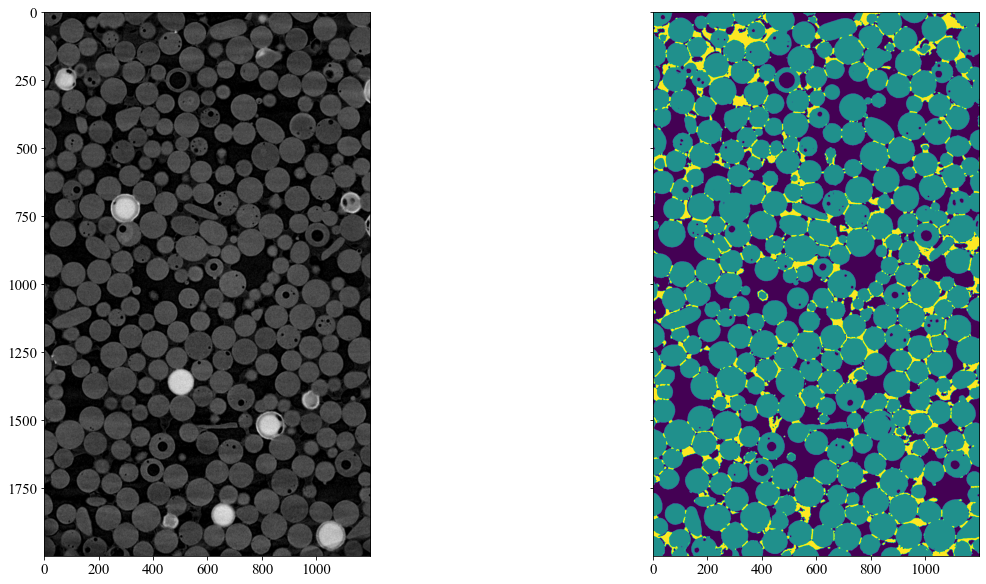

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(20, 10))
ax[0].imshow(raw,cmap="gray")
ax[1].imshow(segmented)

In [6]:
report_fraction(segmented)

porosity: 0.23839875
coke fraction: 0.08185041666666666


## Crop pieces from tiny to big: tiny, small,medium 

shape: (300, 150, 1),size: 45000
porosity: 0.34146666666666664
coke fraction: 0.068


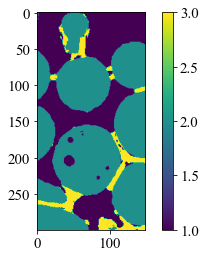

In [7]:
tiny=segmented[500:800,600:750]
print(f"shape: {tiny.shape},size: {tiny.size}")
report_fraction(tiny)
fig,ax=plt.subplots()
im=ax.imshow(tiny)
fig.colorbar(im)

shape: (300, 150, 1),size: 45000
porosity: 0.1711111111111111
coke fraction: 0.11622222222222223


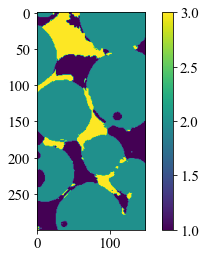

In [35]:
tiny2=segmented[0:300,1050:1200]
print(f"shape: {tiny2.shape},size: {tiny2.size}")
report_fraction(tiny2)
fig,ax=plt.subplots()
im=ax.imshow(tiny2)
fig.colorbar(im)

shape: (300, 400, 1),size: 120000
porosity: 0.2718083333333333
coke fraction: 0.0584


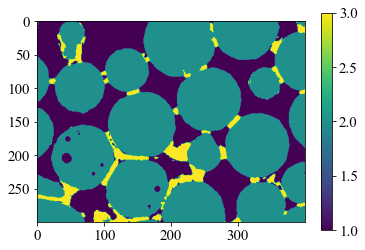

In [8]:
small=segmented[500:800,600:1000]
print(f"shape: {small.shape},size: {small.size}")
report_fraction(small)
fig,ax=plt.subplots()
im=ax.imshow(small)
fig.colorbar(im)

shape: (800, 300, 1),size: 240000
porosity: 0.2780458333333333
coke fraction: 0.07820833333333334


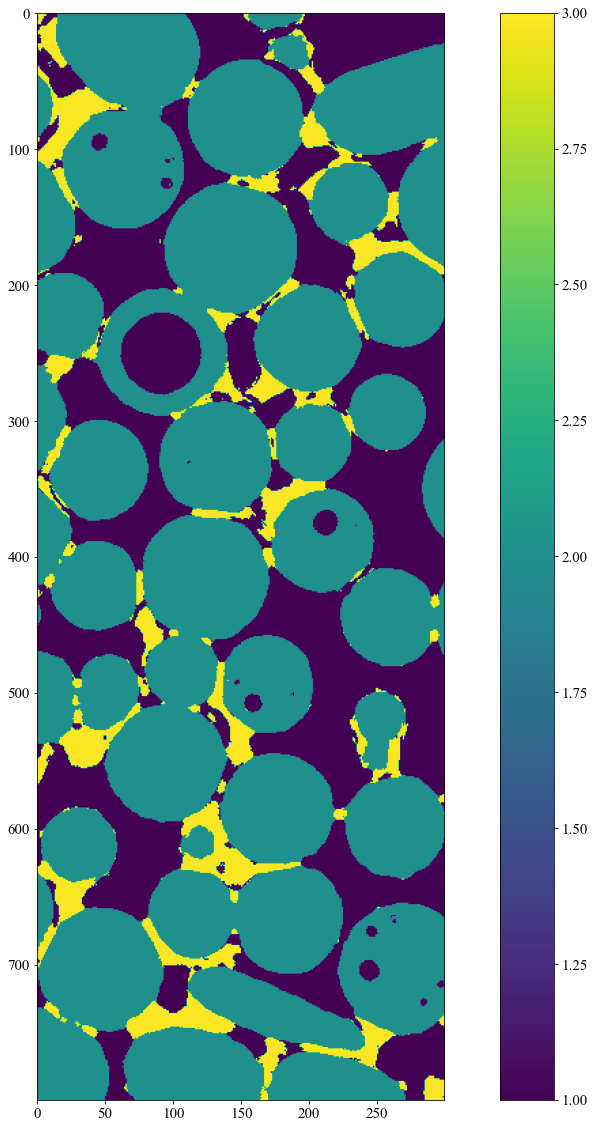

In [9]:
medium=segmented[0:800,400:700]
print(f"shape: {medium.shape},size: {medium.size}")
report_fraction(medium)
fig,ax=plt.subplots(figsize=(20, 20))
im=ax.imshow(medium)
fig.colorbar(im)

shape: (2000, 1200, 1),size: 2400000
porosity: 0.23839875
coke fraction: 0.08185041666666666


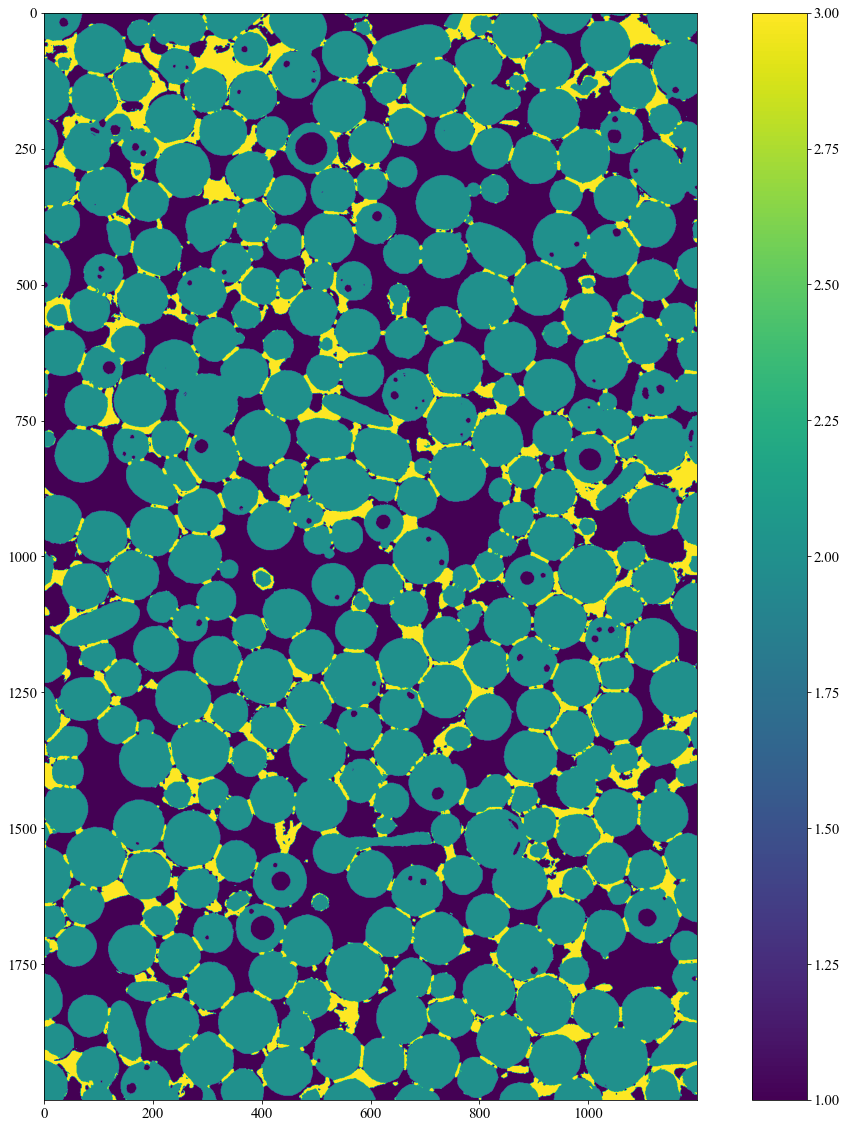

In [10]:
full=segmented[:,:]
print(f"shape: {full.shape},size: {full.size}")
report_fraction(full)
fig,ax=plt.subplots(figsize=(20, 20))
im=ax.imshow(full)
fig.colorbar(im)

## Add additional inlet and outlet zones

### define functions

In [11]:

def add_inlet_outlet(data,length=20):
    old_nx=data.shape[0]
    old_ny=data.shape[1]
    nx=old_nx+2*length
    ny=old_ny
    new=np.ones([nx,ny])#should be equal to the lable of pore
    new[length:length+old_nx,:]=data[0:old_nx,:,0]
    print(f"shape: {new.shape},size: {new.size}")
    report_fraction(new)
    fig,ax=plt.subplots()
    ax.imshow(new)
    return new

### process

shape: (340, 150),size: 51000
porosity: 0.41894117647058826
coke fraction: 0.06


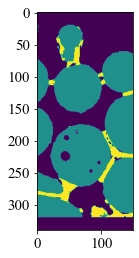

In [12]:
tiny_plus=add_inlet_outlet(tiny)

shape: (340, 150),size: 51000
porosity: 0.26862745098039215
coke fraction: 0.10254901960784314


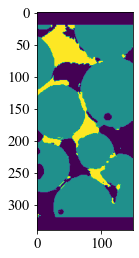

In [37]:
tiny2_plus=add_inlet_outlet(tiny2)

shape: (340, 400),size: 136000
porosity: 0.3574779411764706
coke fraction: 0.05152941176470588


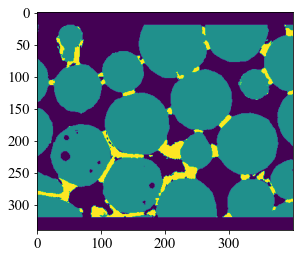

In [13]:
small_plus=add_inlet_outlet(small)

shape: (840, 300),size: 252000
porosity: 0.3124246031746032
coke fraction: 0.07448412698412699


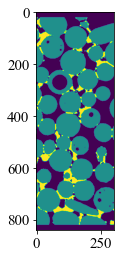

In [14]:
medium_plus=add_inlet_outlet(medium)

shape: (2040, 1200),size: 2448000
porosity: 0.25333210784313726
coke fraction: 0.08024550653594771


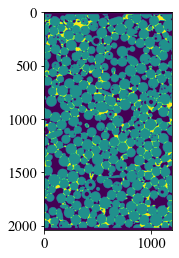

In [15]:
full_plus=add_inlet_outlet(full)

## Export to CokeCombustionFoam Input File Formats

### define the parameters

In [16]:
eps_at_rock_region=0.01
eps_at_coke_region=0.7
eps_at_pore_region=1.0
coke_at_rock_region=0.0
coke_at_coke_region=0.3
coke_at_pore_region=0.0

### define functions

In [17]:
def convert(data,templateDir,targetDir):
    data_2d=data.reshape([data.shape[0],data.shape[1]])
    eps=np.ones([data_2d.shape[0],data_2d.shape[1]])
    eps[:,:]=data_2d[:,:]
    eps[data_2d==label_pore]=eps_at_pore_region
    eps[data_2d==label_coke]=eps_at_coke_region
    eps[data_2d==label_rock]=eps_at_rock_region

    coke=np.ones([data_2d.shape[0],data_2d.shape[1]])
    coke[:,:]=data_2d[:,:]
    coke[data_2d==label_pore]=coke_at_pore_region
    coke[data_2d==label_coke]=coke_at_coke_region
    coke[data_2d==label_rock]=coke_at_rock_region


    fig,ax=plt.subplots(ncols=2)
    ax[0].imshow(eps)
    ax[0].set_title("eps")
    ax[1].imshow(coke)
    ax[1].set_title("coke")


    nx=eps.shape[0]
    ny=eps.shape[1]
    eps_internal_field=list()
    eps_internal_field.append(f"{str(nx*ny)}\n")
    eps_internal_field.append("(\n")
    for j in np.arange(0,ny):
        for i in np.arange(0,nx):
            eps_internal_field.append(f"{str(eps[i,j])}\n")
    eps_internal_field.append(")\n")
    eps_internal_field.append(";\n")

    with open(f"{templateDir}/eps_template","r") as fp:
        eps_template=fp.readlines()
    internal_field_line_index=0
    for index,line in enumerate(eps_template):
        if line.startswith("internalField"):
            internal_field_line_index=index
            for i in range(len(eps_internal_field)):
                eps_template.insert(internal_field_line_index+1+i,eps_internal_field[i])
            break

    if not os.path.exists(f"{targetDir}/0"):
        os.makedirs(f"{targetDir}/0")
    
    if not os.path.exists(f"{targetDir}/system"):
        os.makedirs(f"{targetDir}/system")

    with open(f"{targetDir}/0/eps","w") as fp:
        fp.writelines(eps_template)

    coke_internal_field=list()
    coke_internal_field.append(f"{str(nx*ny)}\n")
    coke_internal_field.append("(\n")
    for j in np.arange(0,ny):
        for i in np.arange(0,nx):
            coke_internal_field.append(f"{str(coke[i,j])}\n")
    coke_internal_field.append(")\n")
    coke_internal_field.append(";\n")

    with open(f"{templateDir}/coke_template","r") as fp:
        coke_template=fp.readlines()
    internal_field_line_index=0
    for index,line in enumerate(coke_template):
        if line.startswith("internalField"):
            internal_field_line_index=index
            for i in range(len(coke_internal_field)):
                coke_template.insert(internal_field_line_index+1+i,coke_internal_field[i])
            break

    with open(f"{targetDir}/0/coke","w") as fp:
        fp.writelines(coke_template)

    with open(f"{templateDir}/blockMeshDict_template","r") as fp:
        mesh_template=fp.readlines()
    for index,line in enumerate(mesh_template):
        if line.startswith("convertToMeters "):
            mesh_template.insert(index+1,f"lx {nx};\n")
            mesh_template.insert(index+2,f"ly {ny};\n")
            mesh_template.insert(index+3,f"Nx {nx};\n")
            mesh_template.insert(index+4,f"Ny {ny};\n")
            break

    with open(f"{targetDir}/system/blockMeshDict","w") as fp:
        fp.writelines(mesh_template)
    


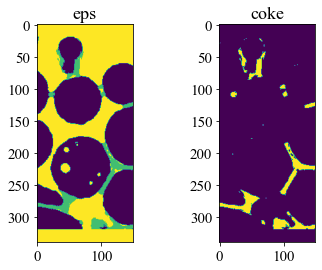

In [18]:
templateDir="./export/template"
targetDir="./export/artifacts/tiny"
convert(tiny_plus,templateDir,targetDir)

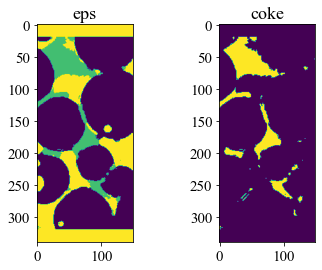

In [38]:
templateDir="./export/template"
targetDir="./export/artifacts/tiny2"
convert(tiny2_plus,templateDir,targetDir)

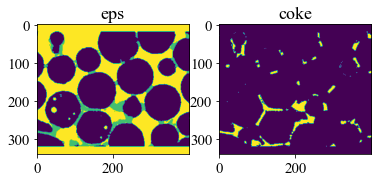

In [19]:
templateDir="./export/template"
targetDir="./export/artifacts/small"
convert(small_plus,templateDir,targetDir)

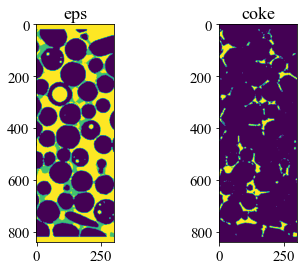

In [20]:
templateDir="./export/template"
targetDir="./export/artifacts/medium"
convert(medium_plus,templateDir,targetDir)

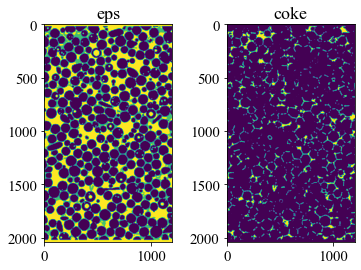

In [21]:
templateDir="./export/template"
targetDir="./export/artifacts/full"
convert(full_plus,templateDir,targetDir)